In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import importlib
import torch

import REINFORCE as rln
import FullRankRNN as rnn

In [2]:
net = rnn.FullRankRNN(input_size=3, hidden_size=128, output_size=3,
                      noise_std=0, alpha=0.2, rho=0.8,
                      train_wi=True, train_wo=True)

net.actor_critic(actor=True)

net.load_state_dict(torch.load("models/FullRankRNN.pt", map_location='cpu'))



<All keys matched successfully>

In [3]:
task = "RDM"
inputs_valid = torch.load("artificial dataset/"+task+'_inputs_valid.pt')
#targets_valid = torch.load("artificial dataset/"+task+'_targets_valid.pt')
#mask_valid = torch.load("artificial dataset/"+task+'_mask_valid.pt')
values_valid = torch.load("artificial dataset/"+task+'_values_valid.pt')
traj = torch.load("artificial dataset/"+task+'traj.pt')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


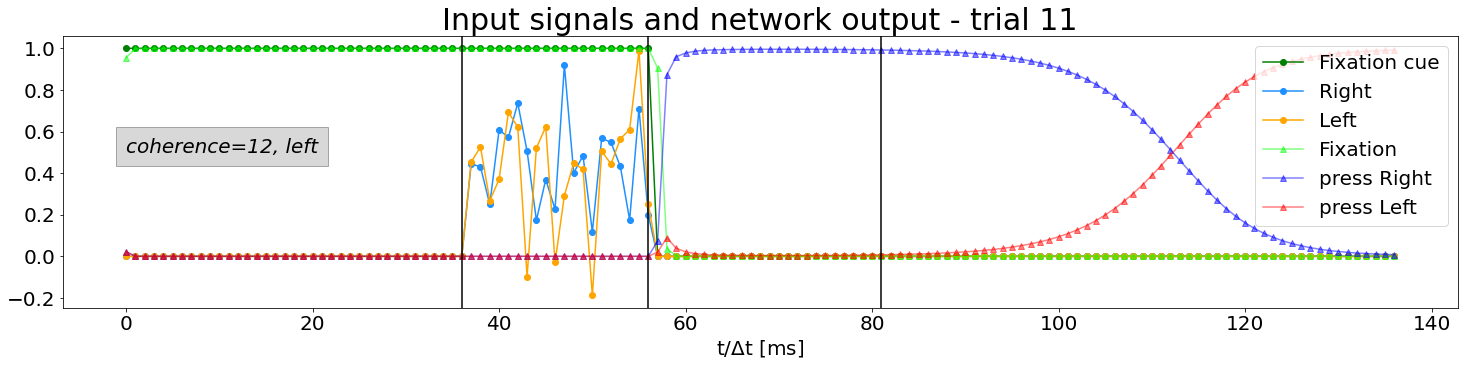

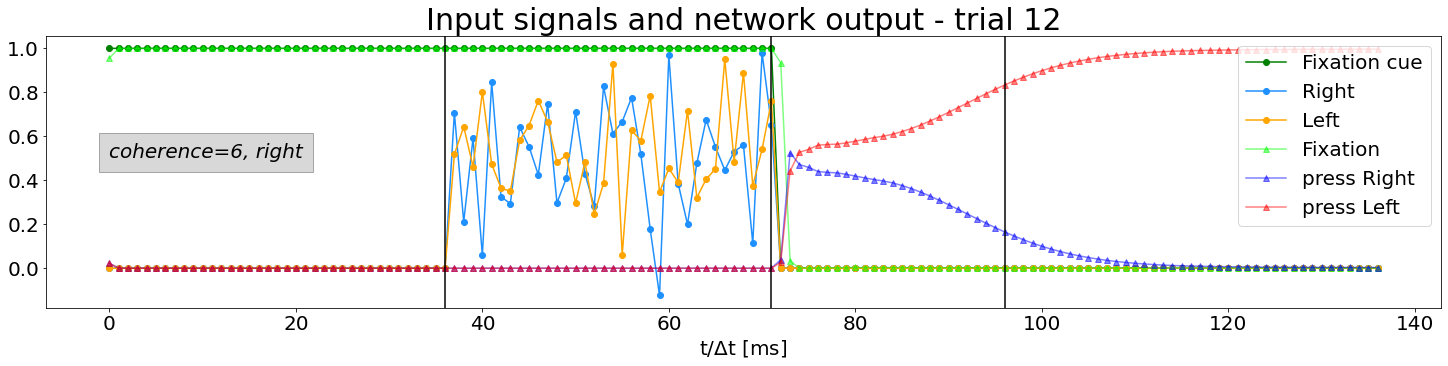

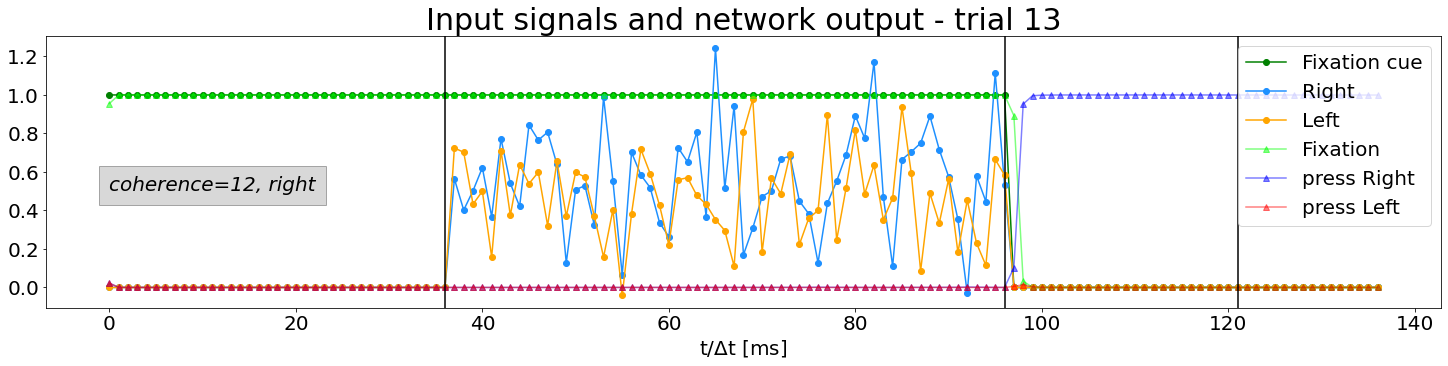

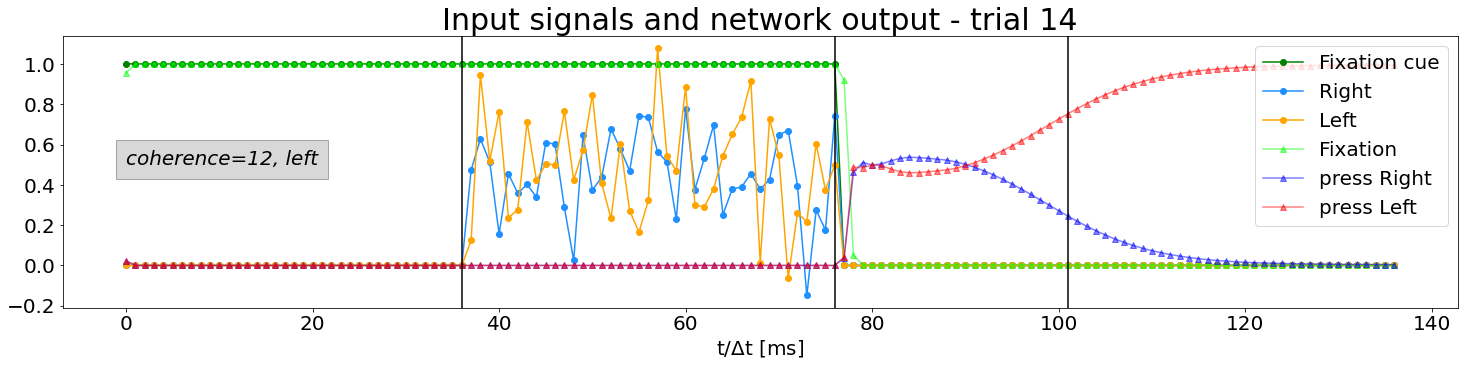

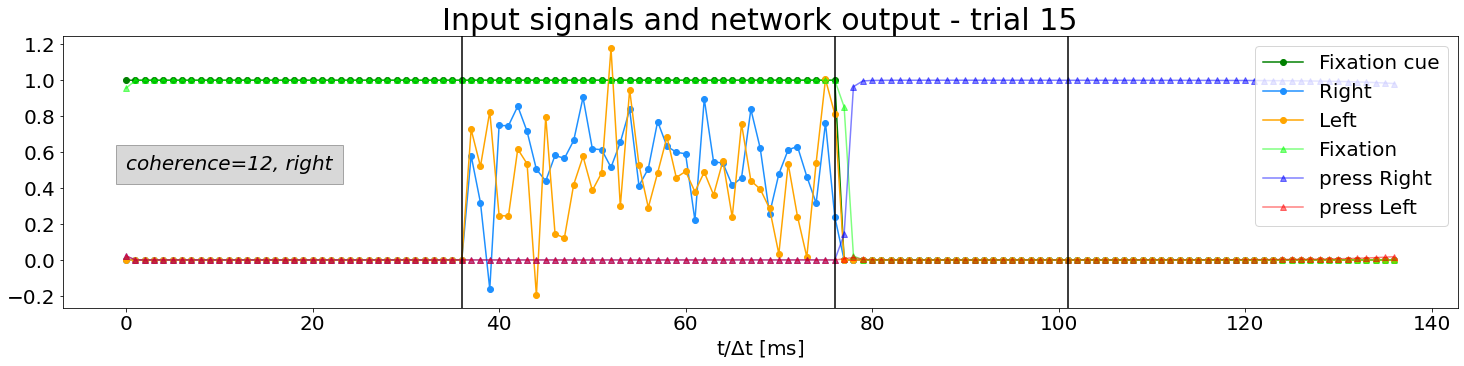

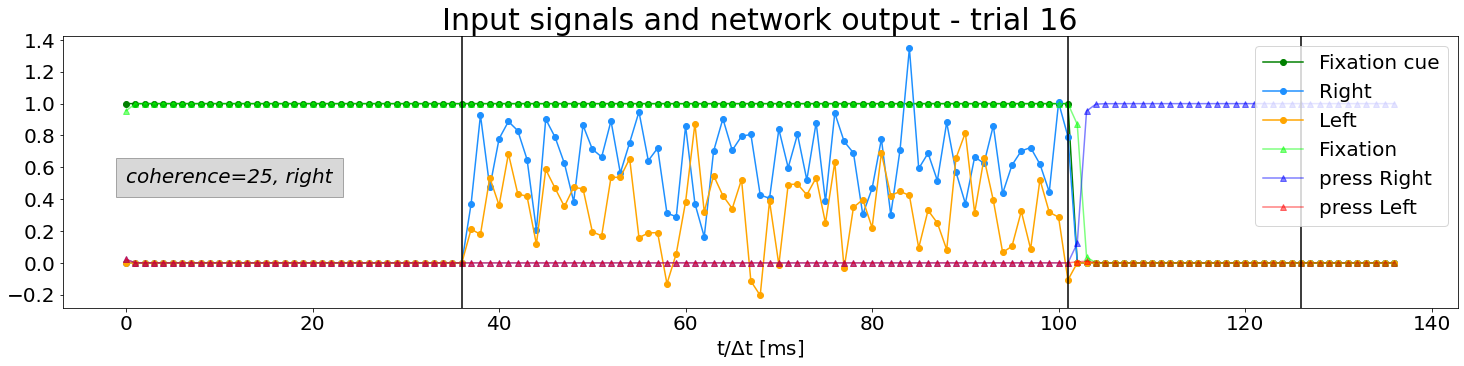

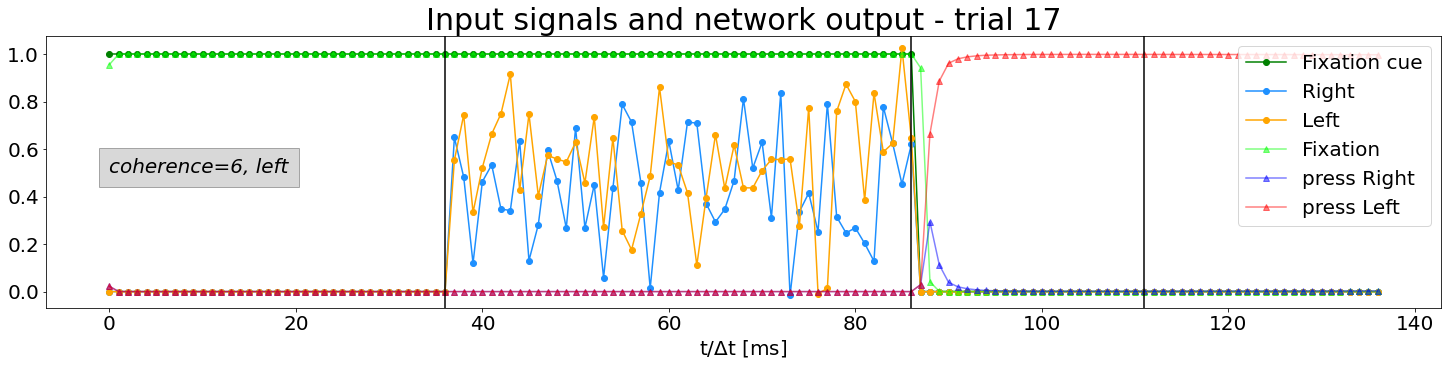

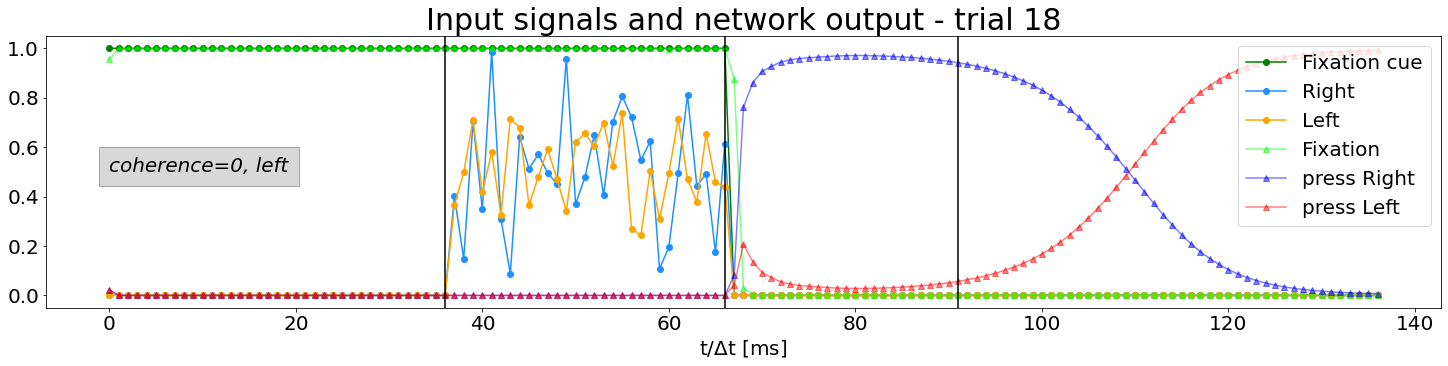

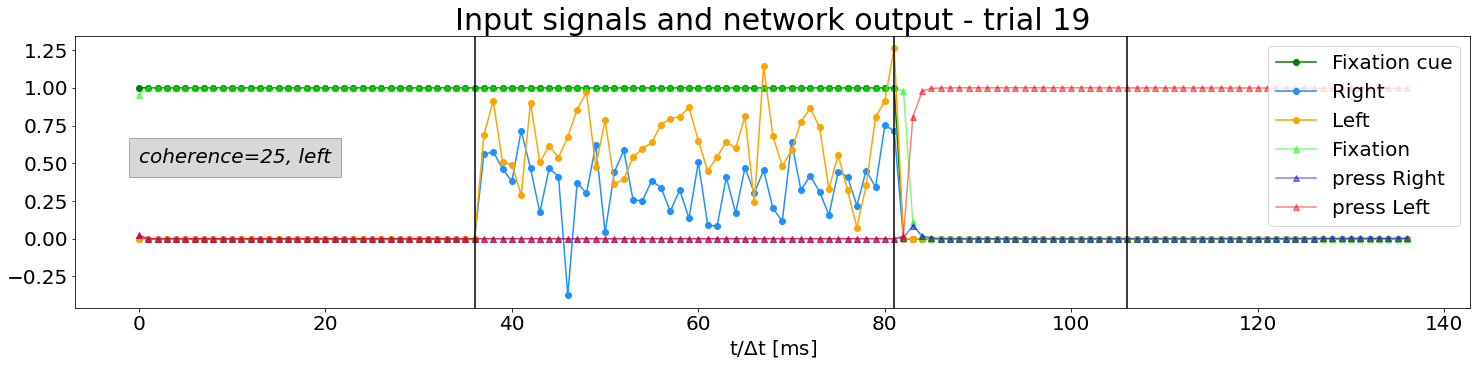

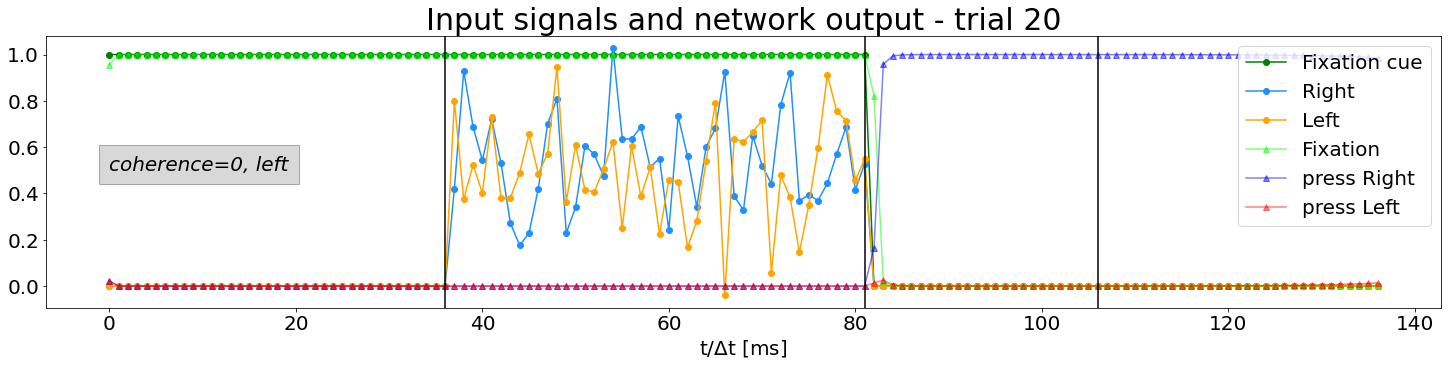

In [4]:
output_valid = net(inputs_valid, return_dynamics = False)#, h0=traj[0][0])
    
for i in range(10):
    plt.figure(figsize=(25,5))
    i=i+10
    
    plt.plot(inputs_valid[i,:,0], "-o", label="Fixation cue", color="green")
    plt.plot(inputs_valid[i,:,1], "-o", label="Right", color="dodgerblue")
    plt.plot(inputs_valid[i,:,2], "-o", label="Left", color="orange")
    plt.plot(output_valid[i,:,0].detach().numpy(), "-^", label="Fixation", color="lime", alpha=0.5)
    plt.plot(output_valid[i,:,1].detach().numpy(), "-^", label="press Right", color="blue", alpha=0.5)
    plt.plot(output_valid[i,:,2].detach().numpy(), "-^", label="press Left", color="red", alpha=0.5)
    
    plt.axvline(values_valid[i][1]-1, color="black")
    plt.axvline(values_valid[i][2]-1, color="black")
    plt.axvline(values_valid[i][3]-1, color="black")
    
    plt.xlabel('t/$\Delta$t [ms]', size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.text(0, 0.5, r'coherence=%i, %s' %(values_valid[i][0], values_valid[i][4]), style='italic', fontsize=20, bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 10})
    plt.legend(fontsize=20, loc="upper right")
    plt.title("Input signals and network output - trial %i" %(i+1), fontsize=30)

In [6]:
#importlib.reload(rln)

reinforce = rln.REINFORCE()

In [7]:
obs, rewards, actions, probs, log_probs, values, trial_begins, gt = reinforce.experience(n_trs=10, name_load="models/FullRankRNN")

tensor([[0., 0., 0.]]) log


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


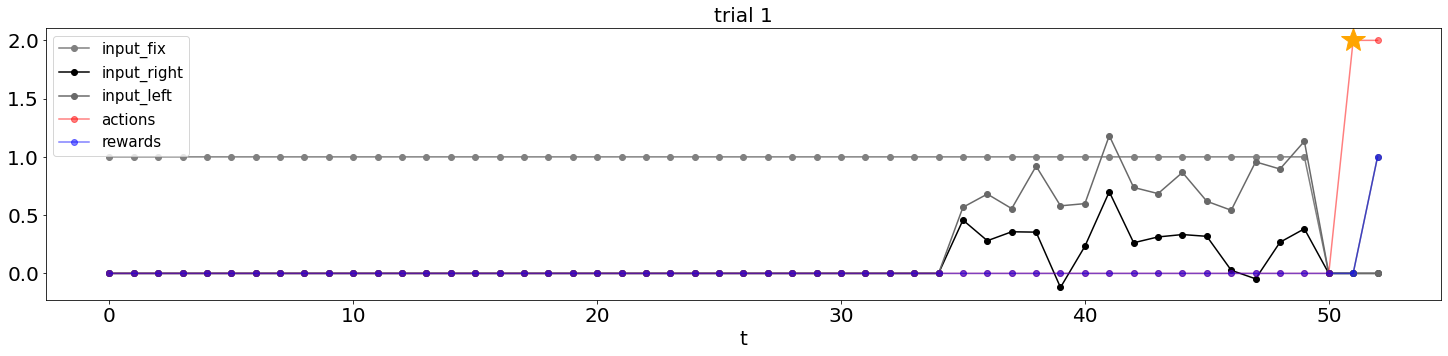

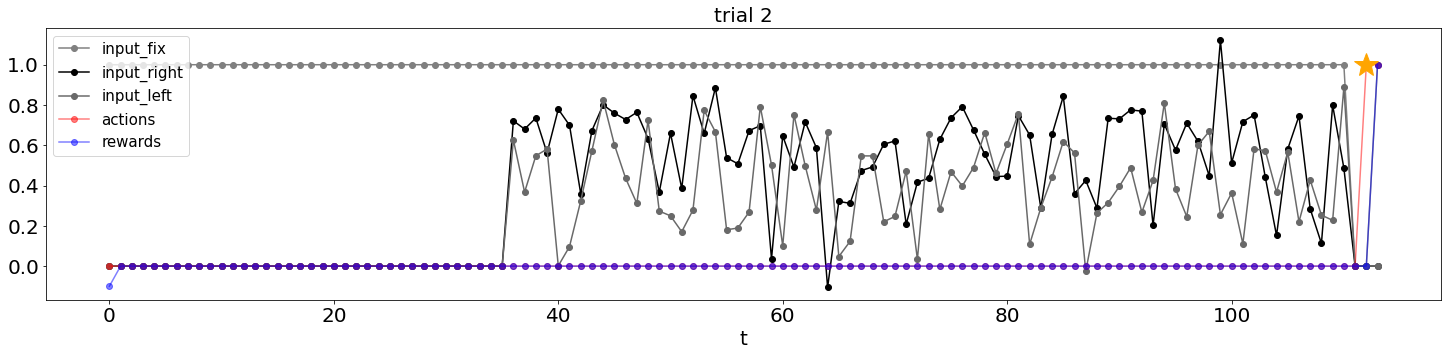

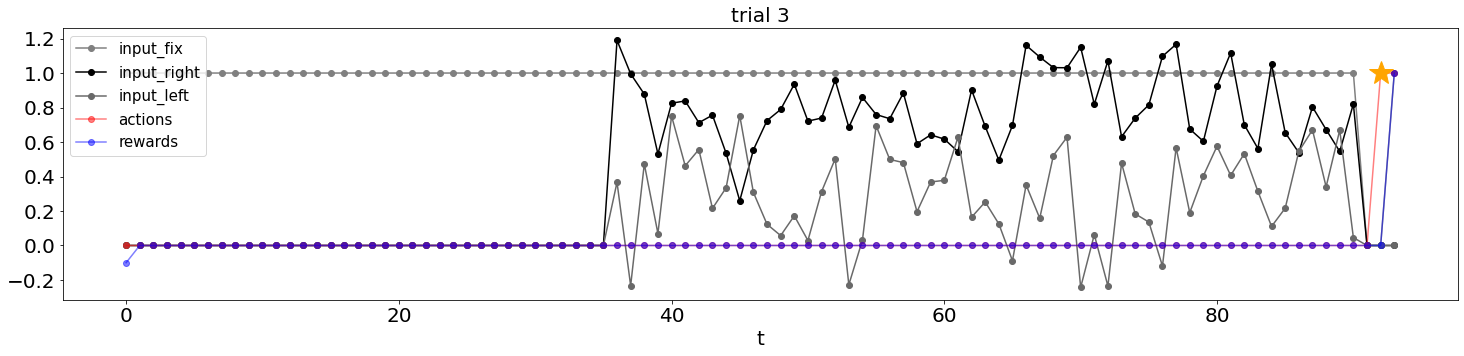

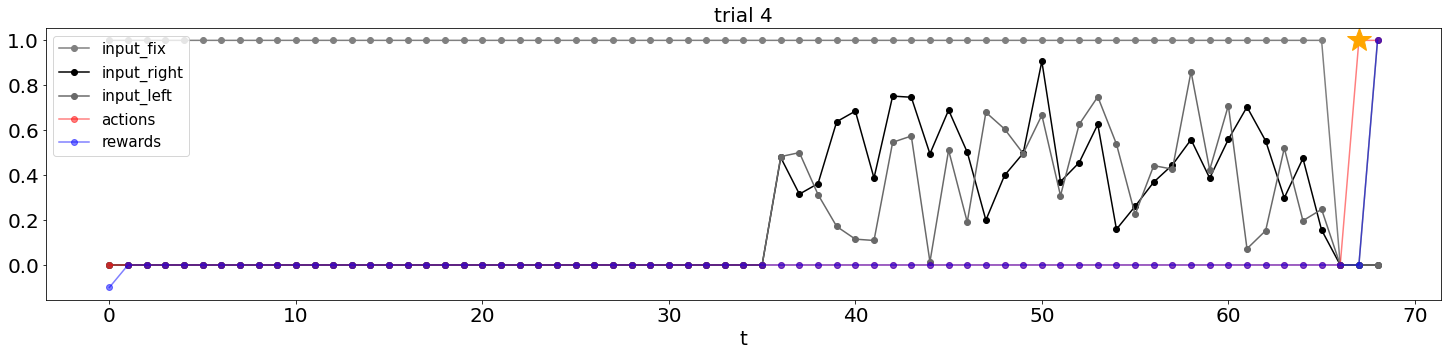

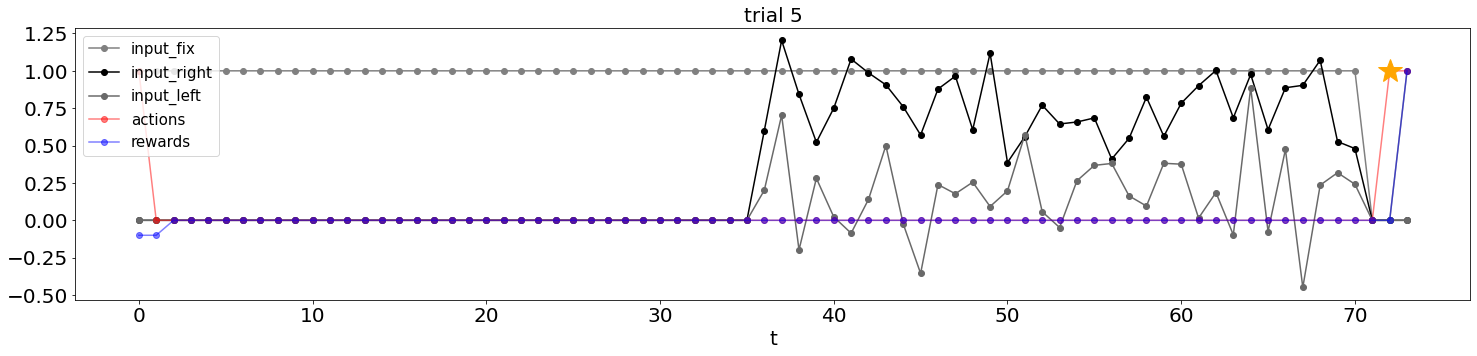

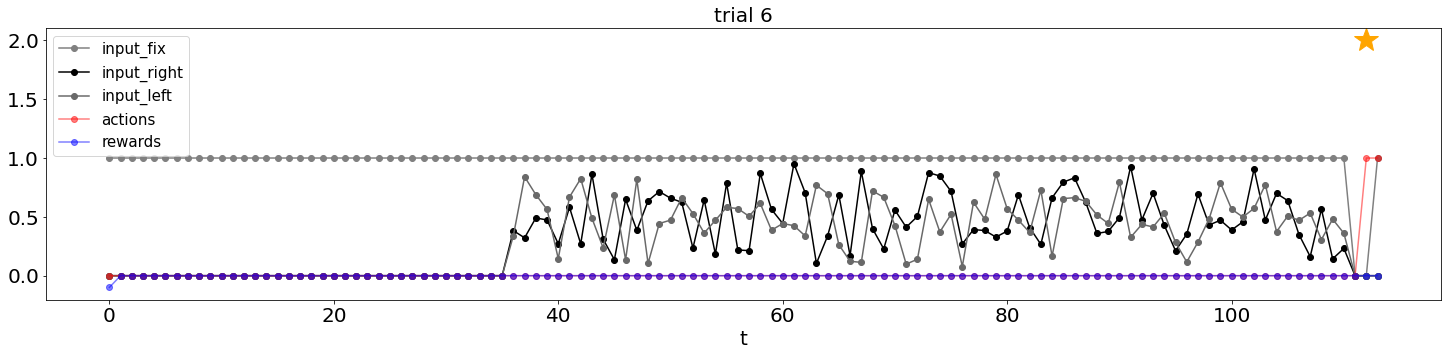

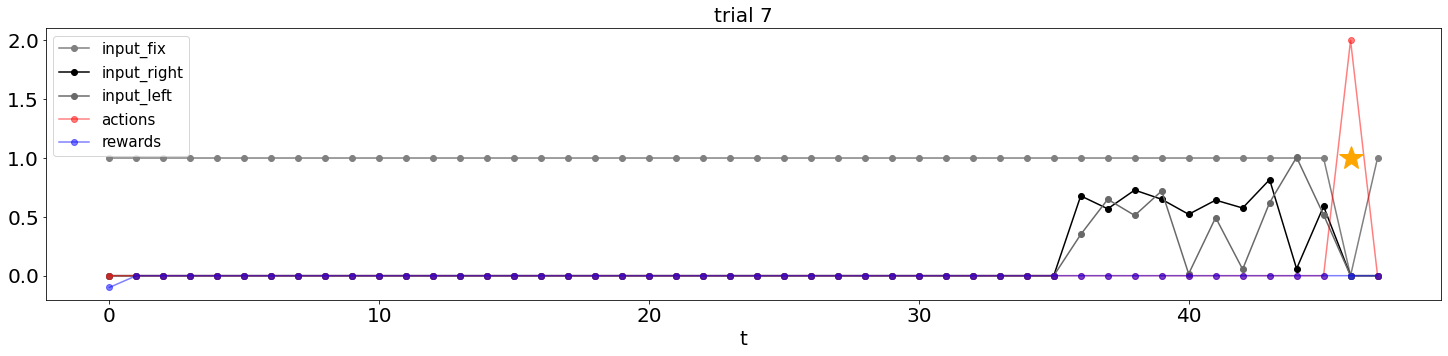

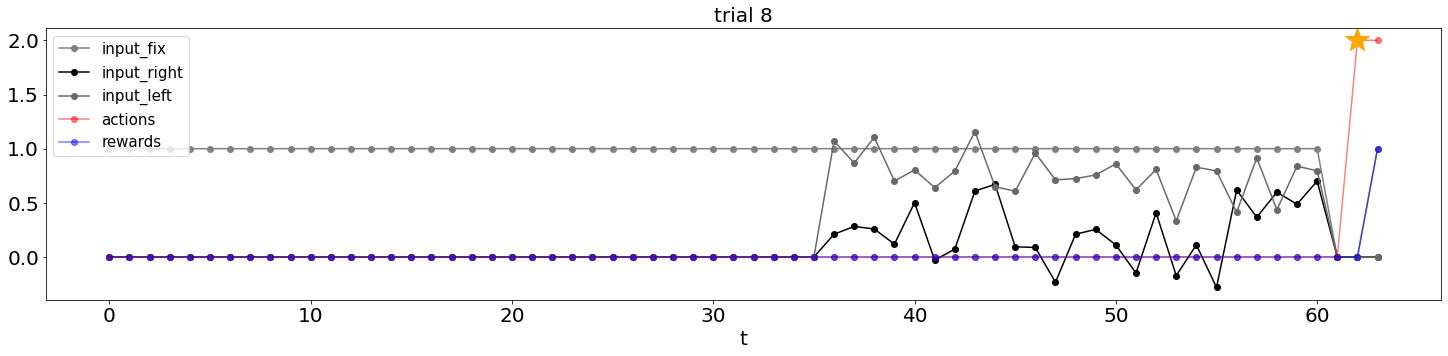

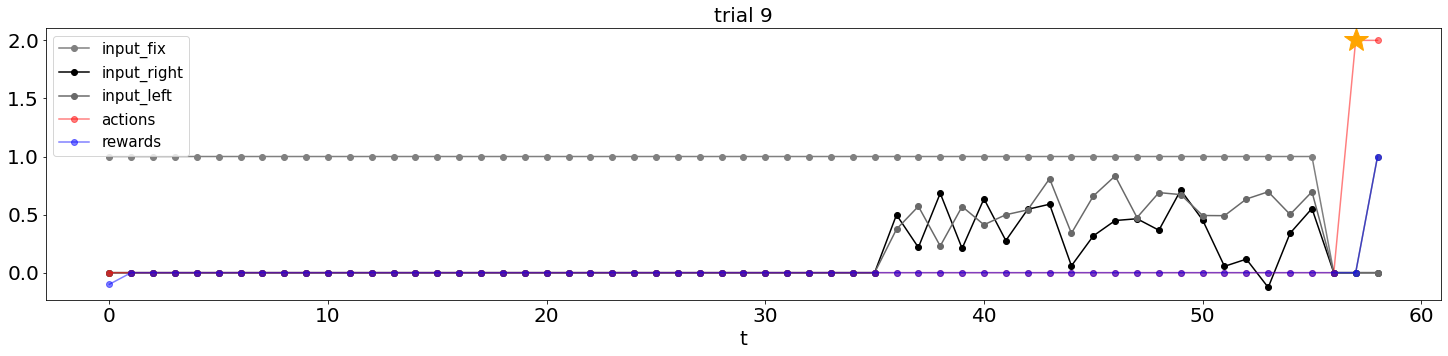

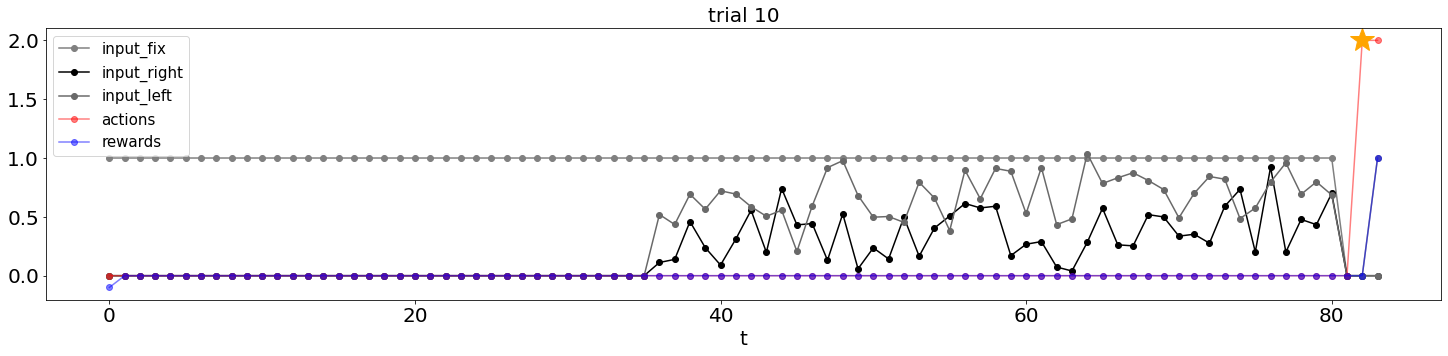

In [8]:
obs = obs.T
length = 0
for i in range(10):

    plt.figure(figsize=(25,5))
    
    start = int(trial_begins[i])
    stop = int(trial_begins[i+1])
     
    plt.plot(obs[0][start:stop], "-o", label="input_fix", color="gray")
    plt.plot(obs[1][start:stop], "-o", label="input_right", color="black")
    plt.plot(obs[2][start:stop], "-o", label="input_left", color="dimgray")
    plt.plot(actions[start:stop], "-o", label="actions", color="red", alpha=0.5)
    plt.plot(rewards[start:stop], "-o", label="rewards", color="blue", alpha=0.5)
    plt.plot(stop-length-2, gt[i], "*", markersize=25, color="orange")
    length += len(obs[0][start:stop])

    plt.xlabel("t", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("trial %i" %(i+1), size=20)
    plt.legend(fontsize=15, loc="upper left");

In [10]:
#torch.autograd.set_detect_anomaly(True)

for i in range(15):
    print(i, "\n")
    reinforce.learning(10, 1e-4)


0 

tensor([[0., 0., 0.]]) log
It took 4.638139s for 10 trials
1 

tensor([[0., 0., 0.]]) log
It took 3.767922s for 10 trials
2 

tensor([[0., 0., 0.]]) log
It took 5.092357s for 10 trials
3 

tensor([[0., 0., 0.]]) log
It took 4.145261s for 10 trials
4 

tensor([[0., 0., 0.]]) log
It took 4.913367s for 10 trials
5 

tensor([[0., 0., 0.]]) log
It took 3.693582s for 10 trials
6 

tensor([[0., 0., 0.]]) log
It took 4.701792s for 10 trials
7 

tensor([[0., 0., 0.]]) log
It took 4.790583s for 10 trials
8 

tensor([[0., 0., 0.]]) log
It took 4.117669s for 10 trials
9 

tensor([[0., 0., 0.]]) log
It took 5.163657s for 10 trials
10 

tensor([[0., 0., 0.]]) log
It took 4.701594s for 10 trials
11 

tensor([[0., 0., 0.]]) log
It took 4.288658s for 10 trials
12 

tensor([[0., 0., 0.]]) log
It took 4.403251s for 10 trials
13 

tensor([[0., 0., 0.]]) log
It took 4.590475s for 10 trials
14 

tensor([[0., 0., 0.]]) log
It took 4.947907s for 10 trials


In [23]:
n_trs = 10
obs, rewards, actions, probs, log_probs, values, store_trial_begin, gt = reinforce.experience(n_trs)

tensor([[0., 0., 0.]]) log


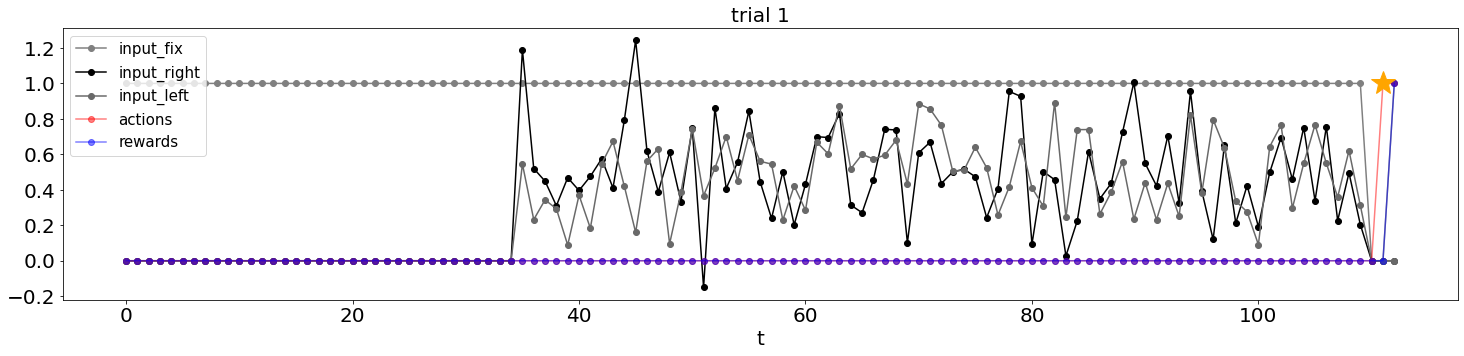

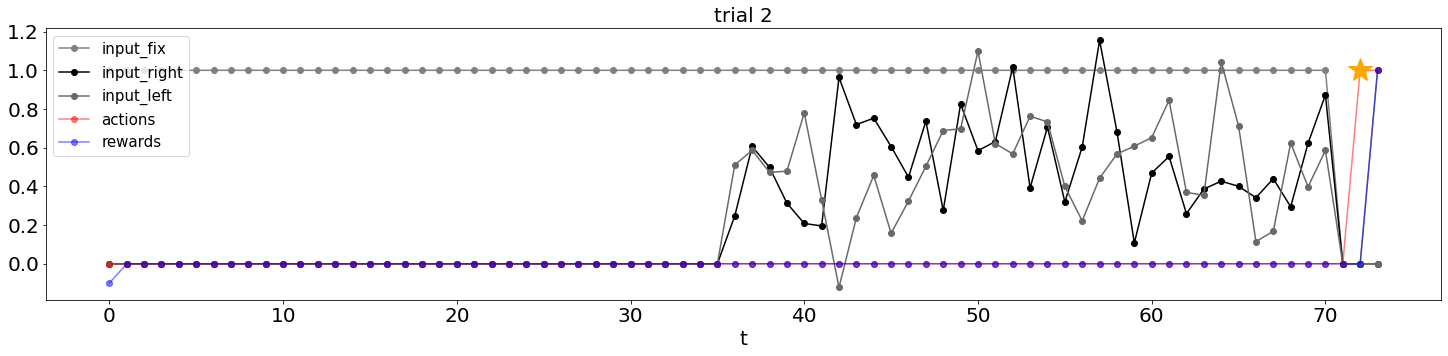

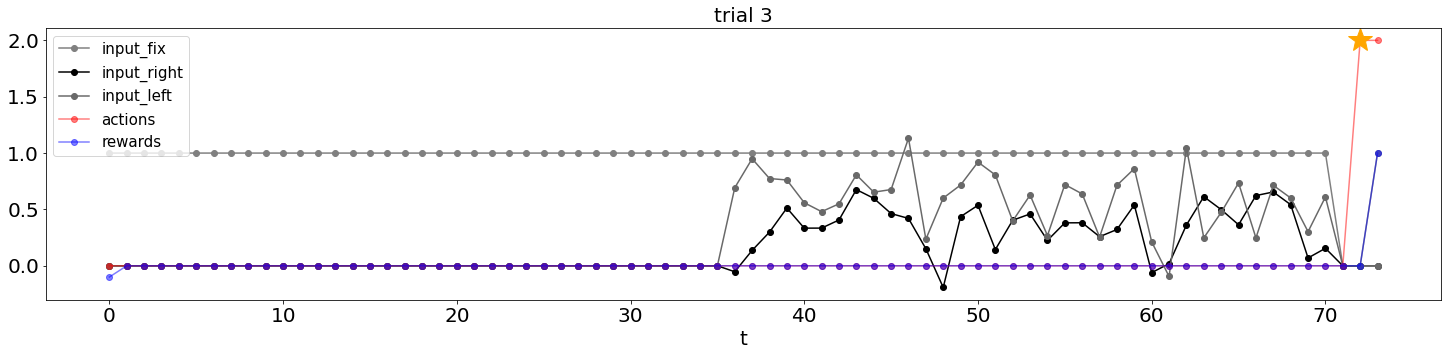

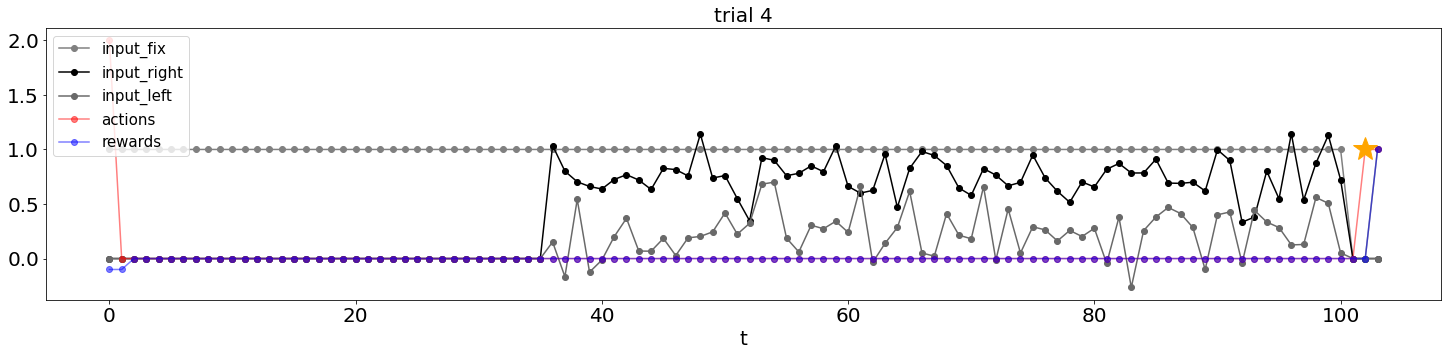

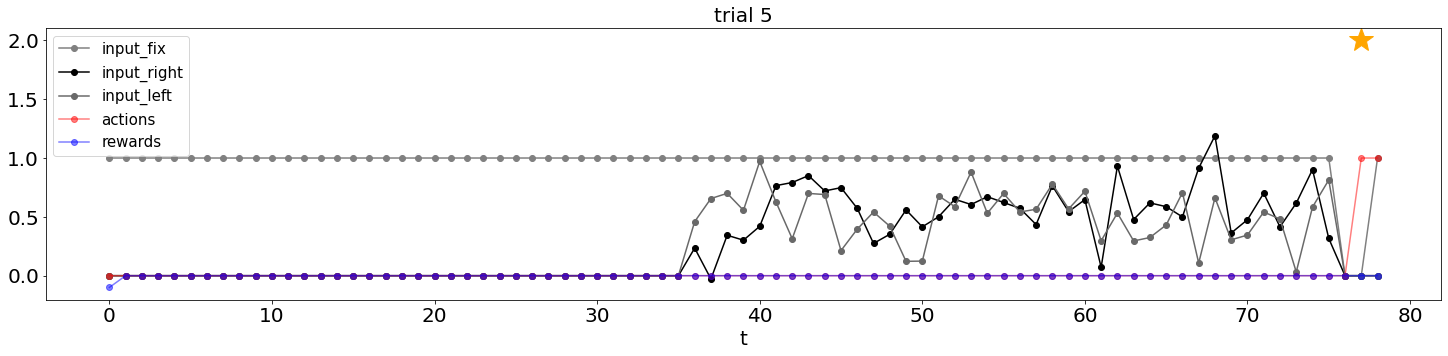

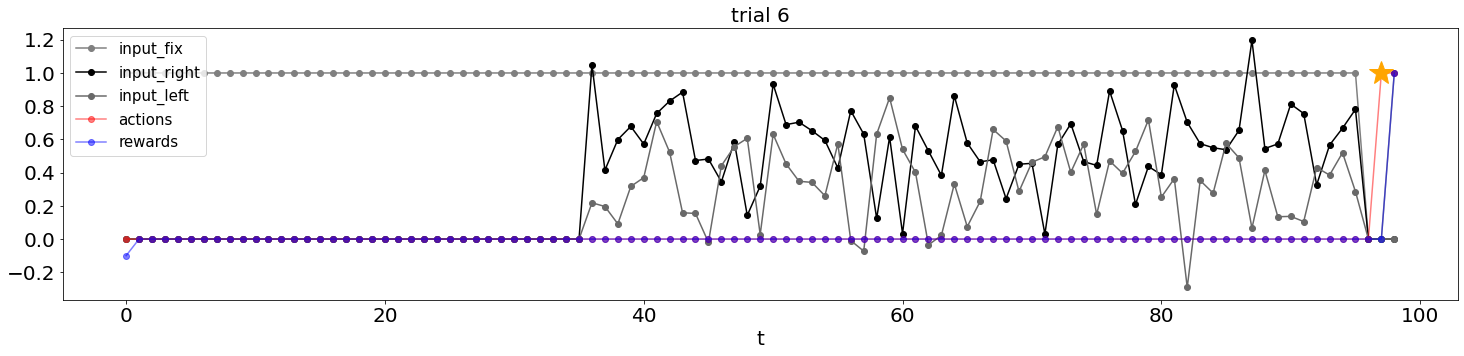

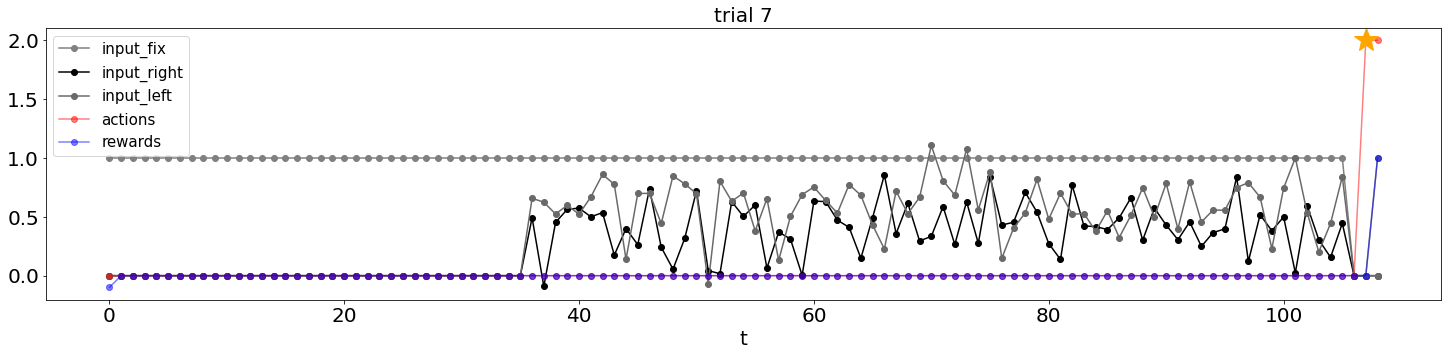

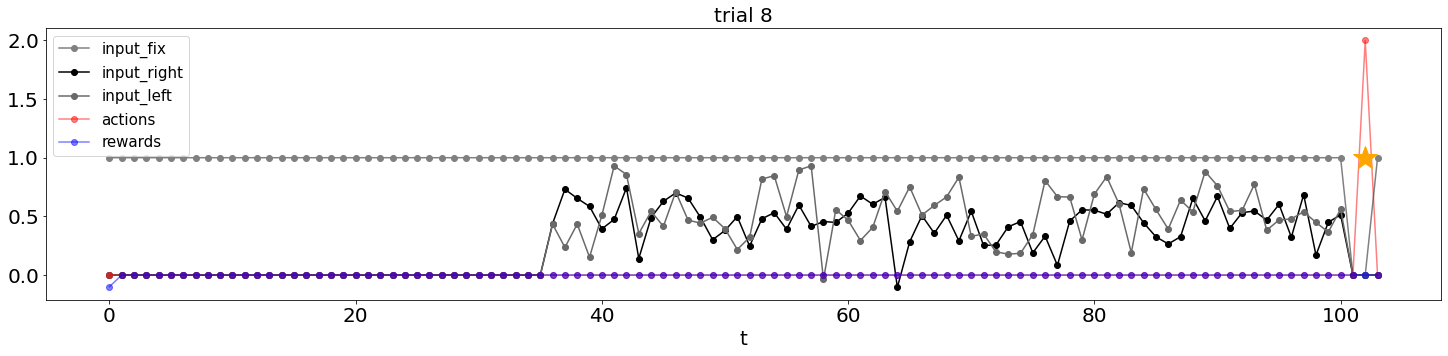

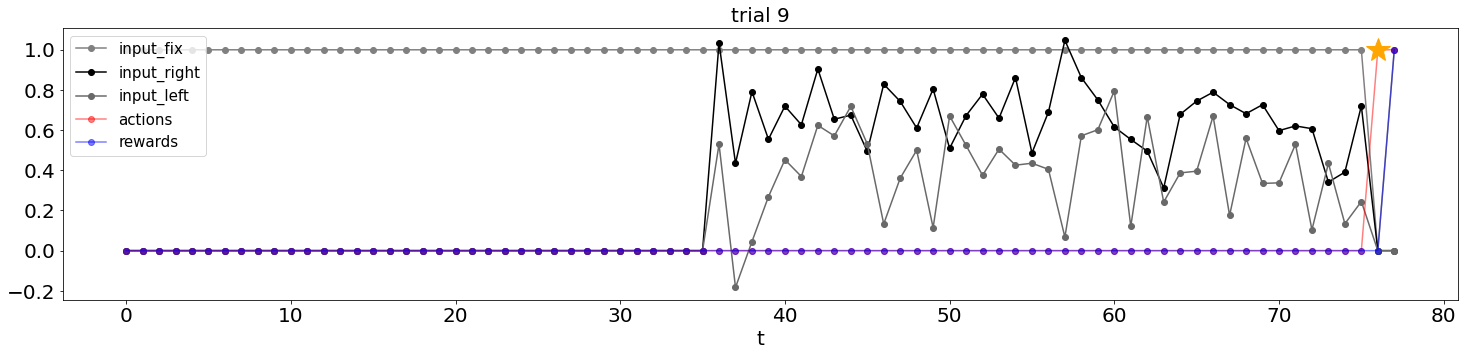

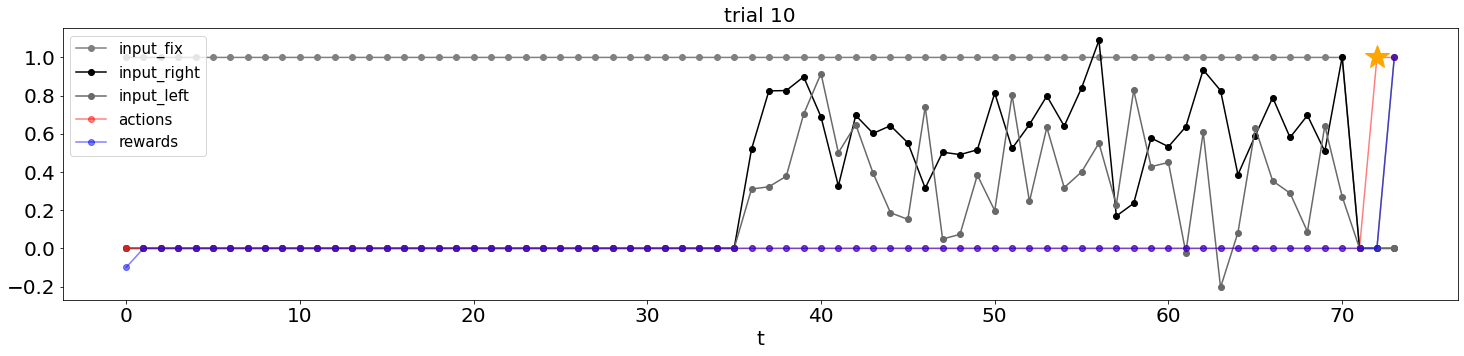

In [24]:
obs = obs.T
length = 0
for i in range(n_trs):

    plt.figure(figsize=(25,5))
    
    start = int(store_trial_begin[i])
    stop = int(store_trial_begin[i+1])
     
    plt.plot(obs[0][start:stop], "-o", label="input_fix", color="gray")
    plt.plot(obs[1][start:stop], "-o", label="input_right", color="black")
    plt.plot(obs[2][start:stop], "-o", label="input_left", color="dimgray")
    plt.plot(actions[start:stop], "-o", label="actions", color="red", alpha=0.5)
    plt.plot(rewards[start:stop], "-o", label="rewards", color="blue", alpha=0.5)
    plt.plot(stop-length-2, gt[i], "*", markersize=25, color="orange")
    length += len(obs[0][start:stop])

    plt.xlabel("t", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("trial %i" %(i+1), size=20)
    plt.legend(fontsize=15, loc="upper left");